# Step 1: Importing Libraries

In [ ]:
import os
os.environ['IPYTHON_SUPPRESS_DEPRECATED_CONFIGS'] = '1'
from google.colab import drive

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates


import warnings
warnings.filterwarnings('ignore')

from mlxtend.frequent_patterns import apriori, association_rules
from itertools import permutations


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Step 2: Dataset Loading & Preprocessing

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Update the route to access the data:
#route = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/df_final_version.csv'
#destination = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/Apriori_rules/'

#in case you accessing the google shared drive use this and discard the previous by adding a # before and deleting the # in the next line:
route = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/df_merged_version.csv'
destination = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/Apriori_rules'

In [ ]:
# Path to the CSV file
file_path = route

# Read the CSV file into a DataFrame
orders = pd.read_csv(file_path)

orders.head(5)

,id_orden,id_producto,incluido_orden_carrito,reordenado,nombre_producto,id_pasillo,id_departamento,pasillo,departamento,incluido_orden_carrito_normalized,...,departamento_SIN CATALOGAR,total_orders_per_product,total_reorders_per_product,reorder_rate_per_product,order_size,position_in_order,product_popularity_in_department,product_popularity_in_aisle,cluster,cluster2
0,1,49302,1,1,EL YOGUR DE BULGARIA,120.0,16.0,YOGUR,HUEVOS Y LÁCTEOS,0.000000,...,0.0,0.000374,0.000423,0.875000,0.076923,0.000000,0.000374,0.000374,3,1
1,1,11109,2,1,4% ORGÁNICO QUESO GRASA DE LECHE LECHE ENTERA ...,108.0,16.0,OTROS QUESOS CREMAS,HUEVOS Y LÁCTEOS,0.012821,...,0.0,0.007637,0.006463,0.743056,0.076923,0.001832,0.007637,0.007637,3,1
2,1,10246,3,0,CORAZONES DE APIO ORGÁNICOS,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS,0.025641,...,0.0,0.056662,0.034366,0.535782,0.076923,0.003663,0.056662,0.056662,3,1
3,1,49683,4,0,KIRBY PEPINO,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS,0.038462,...,0.0,0.128812,0.103219,0.708247,0.076923,0.005495,0.128812,0.128812,3,1
4,1,43633,5,1,LAS SARDINAS LIGERAMENTE AHUMADO EN ACEITE DE ...,95.0,15.0,MARISCOS CARNE ENLATADA,PRODUCTOS ENLATADOS,0.051282,...,0.0,0.001228,0.000604,0.416667,0.076923,0.007326,0.001228,0.001228,3,1


In [ ]:
orders.shape

(1369699, 176)

**Preprocessing the data to convert it into a suitable format for the aprior algorithm.**


Creating a list of products

In [ ]:
# We group by id_orden and create a list of items for each id_orden
df = orders.groupby('id_orden')['nombre_producto'].apply(list).reset_index()

df.rename(columns={'nombre_producto': 'Transaction'}, inplace=True)

In [ ]:
#Printing the first 5 rows of the dataframe
df.head()

,id_orden,Transaction
0,1,"[EL YOGUR DE BULGARIA, 4% ORGÁNICO QUESO GRASA..."
1,36,"[QUESO RALLADO PECORINO ROMANO, AGUA DE MANANT..."
2,38,"[SIN CÁSCARA PISTACHOS, ORGÁNICA BIOLOGIQUE LI..."
3,96,"[PAVO ASADO, PEPINO ORGÁNICA, LOS TOMATES ORGÁ..."
4,98,"[AGUA NATURAL DE MANANTIAL, ZUMO DE NARANJA OR..."


In [ ]:
df.shape

(131153, 2)

Below we'll convert the transactions into a list of lists.

In [ ]:
# Split transaction strings into lists
transactions = df['Transaction'] #.apply(lambda t: t.split(','))

# Convert DataFrame column into list of strings
transactions = list(transactions)

# Print the list of transactions, first 5 items
print(transactions[:5])

[['EL YOGUR DE BULGARIA', '4% ORGÁNICO QUESO GRASA DE LECHE LECHE ENTERA COTTAGE', 'CORAZONES DE APIO ORGÁNICOS', 'KIRBY PEPINO', 'LAS SARDINAS LIGERAMENTE AHUMADO EN ACEITE DE OLIVA', 'BOLSA DE BANANO ORGÁNICO', 'QUESO ORGÁNICO TOTAL CADENA'], ['QUESO RALLADO PECORINO ROMANO', 'AGUA DE MANANTIAL', 'ORGÁNICA DE HALF & HALF', 'ENSALADA DE VERDES ESTUPENDOS', 'JAULA LIBRE EXTRA GRANDE GRADO AA HUEVOS', 'JAMÓN, AMERICANO', 'GRANATE ORGÁNICO PATATA DULCE (YAM)', 'ESPÁRRAGOS'], ['SIN CÁSCARA PISTACHOS', 'ORGÁNICA BIOLOGIQUE LIMES', 'ORGÁNICO SIN PROCESAR SIN FILTRAR VINAGRE DE MANZANA', 'ORGÁNICA RÚCULA BEBÉ', 'HOT HOUSE ORGÁNICA TOMATE', 'GUISANTES VERDES', 'AGRUPADO CILANTRO', 'DE PEREJIL, RAMO', 'ENELDO FRESCO'], ['PAVO ASADO', 'PEPINO ORGÁNICA', 'LOS TOMATES ORGÁNICOS DE UVA', 'GRANADA ORGÁNICA NÚCLEOS', 'LAS FRAMBUESAS ORGÁNICAS', 'TODO ORGÁNICO FRESAS', 'LOS ARÁNDANOS ORGÁNICOS'], ['AGUA NATURAL DE MANANTIAL', 'ZUMO DE NARANJA ORGÁNICA CON CALCIO Y VITAMINA D', 'LECHE ENTERA GRIEGA BL

In [ ]:
print(f'Number of transactions: {len(transactions)}.')

Number of transactions: 131153.


In [ ]:
# Step 1: Flatten the list of lists
flattened_list = [item for sublist in transactions for item in sublist]

# Step 2: Convert the flattened list to a set to get unique values
unique_values = set(flattened_list)

# Step 3: (Optional) Convert the set back to a list if needed
unique_values_list = list(unique_values)

#Printing number of unique combination of transactions:
print(f'Number of unique products: {len(unique_values_list)}.')

Number of unique products: 38403.


In [ ]:
# Step 1: Convert each transaction (sublist) to a tuple
transactions_as_tuples = [tuple(transaction) for transaction in transactions]

# Step 2: Create a set of these tuples to get unique transactions
unique_transactions = set(transactions_as_tuples)

# Step 3: Calculate the number of unique transactions
number_of_unique_transactions = len(unique_transactions)

# Output the number of unique transactions
print(f"Number of unique transactions: {number_of_unique_transactions}")

Number of unique transactions: 126821


As we can see we have a total of **131.153 transactions**, **38.403 different products** and **126.821  different baskets (unique product combinations)**.

We will use combinations of 2 products as by increasing the number of item combinations to 3 we would get a lot more possible rules. We need to find a better way to filter out this rules as the combinations grow exponentially.

We'll use the **apriori algorithm** as it allows us to filter out irrelevant items.

The main advantage of this algorithm is that it calculates the support of an item (the frequency of an item). Upon deciding on a min threshold, if an item appears to be infrequent the algorithm won't calculate all possible rules associated to it. This serves as an initial filter.

Before we can run the algorithm we need to **preprocess the data**.

The first step is to transform the dataset into a **onehot encoded dataframe**.

Each column will correspond to a possible item and the rows are the transactions. If a transaction contains the item the corresponding column will be `True`, otherwise `False`.

In [ ]:
# Import the transaction encoder function from mlxtend
from mlxtend.preprocessing import TransactionEncoder

# Instantiate transaction encoder and identify unique items in transactions
encoder = TransactionEncoder().fit(transactions)

# One-hot encode transactions
onehot = encoder.transform(transactions)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_)

# Print the one-hot encoded transaction dataset
onehot.head()

,# 2 FILTROS DE CAFÉ,# 2 FILTROS DE CAFÉ BLANCA DEL CONO,# 2 LÁPICES MECÁNICOS,# 4 BROWN NATURAL FILTROS DE CAFÉ,& ¡IR! AVELLANAS STICKS + PRETZEL,'N' BESOS GALLETAS CRÈME CARAMELOS,+ ENERGÍA VEGETAL NEGRO CEREZA Y JUGO DE FRUTAS,"+ FRÍO GRIPE, MULTI-SYMPTOM, DÍA Y NOCHE, FUERZA MÁXIMA, CAPSULAS",", EXTRA CRISPY RESTAURANTE SAZONADO ESTILO FRANCÉS PATATAS FRITAS",-CABEZA A PIES DE LAVADO DE BEBÉ,...,ÚLTIMA OMEGA D3,ÚLTIMA PEPPRONI ULTRA THIN / CRUJIENTE PIZZA,ÚLTIMA QUESO VELVEETA MAC CHEESY SARTENES,ÚLTIMA RELUCIENTE DE LIMPIO MENTA ESENCIAL DE HIGIENE BUCAL,ÚLTIMA REVUELVA FREÍR VERDURAS MIXTAS,ÚLTIMA SALCHICHONES ULTRA THIN CRUST PIZZA,ÚLTIMA SALSA DE CHOCOLATE,ÚLTIMA SOFTENING LOTION,ÚLTIMO GO FRESH REVIVE GRANADA Y LIMÓN VERBENA OLOR DESODORANTE ANTITRANSPIRANTE,ÚNICAMENTE DE SHARP MOSTAZA
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
onehot.shape

(131153, 38403)

# Step 3: Overview of market basket analysis:

Standard procedure for market basket analysis:

1. Generate large set of rules.
2. Filter rules using metrics.
3. Apply intuition and common sense.

## Generating rules:
- Number of rules grows exponentially in number of items.
- Most rules are not useful.
- Must apply initial round of filtering.

# Apriori algorithm:

- Not possible to count all possible itemsets (total number of combinations = 2**N where N is numbers of items.)

- Retain items that are frequent and contain a min level of support.
- Prune items based on associating rules. Retain frequent sets and prune sets not known to be frequent.

- Computing support once for Item allows to remove further further possible combinations without enumerating them.

The Apriori principle tells us that subsets of frequent itemsets are frequent. Thus, if we find an infrequent itemset, which we'll call {X}, then it must be the case that {X, Y} is also infrequent, so we may eliminate it without computing its support.



If we use **different configurations for support and max length (number of items) we will get different number of rules**.

Below are two examples when we lower the support threshold and we get a higher number of possible rules.

Compute frequent itemsets using a support of 0.003 and length of 3
frequent_itemsets_1 = apriori(onehot, min_support = 0.003,
                            max_len = 3, use_colnames = True)

Compute frequent itemsets using a support of 0.001 and length of 3 --> a smaller support should give more rules
frequent_itemsets_2 = apriori(onehot, min_support = 0.001,
                            max_len=3, use_colnames = True)

Print the number of freqeuent itemsets
print(f"First combination returns {len(frequent_itemsets_1)} rules while second combination:  {len(frequent_itemsets_2)}")

In [ ]:
# Import apriori from mlxtend
from mlxtend.frequent_patterns import apriori

# Compute frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(onehot,  #df as one-hot encoding
                            min_support = 0.006, #minimum support to use
                            max_len = 3, #max number of itemset combinations.
                            use_colnames = True)

# Print a preview of the frequent itemsets
frequent_itemsets.head()

,support,itemsets
0,0.009073,(100% DE PAPEL RECICLADO TOALLAS)
1,0.017522,(100% PAN DE TRIGO ENTERO)
2,0.009897,(100% RAW AGUA DE COCO)
3,0.012199,(2% REDUCCIÓN DE GRASA DE LECHE)
4,0.015775,(ACEITE DE OLIVA VIRGEN EXTRA)


In [ ]:
#Print the last combinations of itemsets --> we see that these combinations include 3 items.
frequent_itemsets.tail()

,support,itemsets
250,0.007754,"(FRESAS ORGÁNICAS, LIMÓN GRANDE)"
251,0.009676,"(FRESAS ORGÁNICAS, LOS ARÁNDANOS ORGÁNICOS)"
252,0.007541,"(FRESAS ORGÁNICAS, ORGÁNICA LECHE ENTERA)"
253,0.007869,"(PEPINO ORGÁNICA, FRESAS ORGÁNICAS)"
254,0.012161,"(LIMÓN GRANDE, LIMAS)"


In [ ]:
print(f'Number of itemsets generated: {len(frequent_itemsets)} ')

Number of itemsets generated: 255 


## Pruning based on association rules:

As we have many possible itemsets combinations we have to decide how to filter out these rules.

We can use the Association Rules function to filter them based on different association rules.

In [ ]:
# We check the documentation of association_rules to understand the different metrics avaialble for pruning.
#help(association_rules)

After instantiating the apriori algorithm to find the frequent itemsets we run the function `association_rules` to filter these rules based on a `min_threshold` for the `metric` we choose.

Below we'll make the pruning based on `support` by setting a min threshold of 0.0015.

In [ ]:
# Import the association rule function from mlxtend
from mlxtend.frequent_patterns import association_rules

# Compute all association rules for frequent_itemsets based on a min_threshold for support.
rules = association_rules(frequent_itemsets,
                            metric = "support",  #possible metrics = 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'leverage', 'conviction', 'zhangs_metric], dtype='object')

                         	min_threshold = 0.0015)

In [ ]:
#Print number of rules using a min threshold of 0.0015 and 'support' metric.
print(f'Number of rules generated after prunning: {len(rules)}. ')

Number of rules generated after prunning: 116. 


In [ ]:
#sampling some of the rules generated:
rules.sample(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
56,(BOLSA DE BANANO ORGÁNICO),(CALABACÍN ORGÁNICO),0.11803,0.034990,0.007937,0.067248,1.921941,0.003807,1.034584,0.543888
16,(ESPINACA ORGÁNICA DEL BEBÉ),(AJO ORGÁNICO),0.07460,0.031703,0.006267,0.084015,2.650020,0.003902,1.057109,0.672838
93,(ESPINACA ORGÁNICA DEL BEBÉ),(FRESAS ORGÁNICAS),0.07460,0.083063,0.012497,0.167518,2.016756,0.006300,1.101450,0.544796
19,(BANANA),(CALABACÍN ORGÁNICO),0.14278,0.034990,0.007160,0.050144,1.433114,0.002164,1.015955,0.352557
53,(BANANA),(PIMIENTOS ROJOS),0.14278,0.023027,0.006443,0.045124,1.959670,0.003155,1.023142,0.571277


As we have 116 rules we need to filter them to find the most relevant ones.

**Metrics of association that we can use to filter rules:**

-  **support(A->C)** = support(A+C) [aka 'support']
  
  range: [0, 1]
    
- **confidence(A->C)** = support(A+C) / support(A)
  
  range: [0, 1]
    
- **lift(A->C)** = confidence(A->C) / support(C)
  
  range: [0, inf]
    
- **leverage(A->C)** = support(A->C) - support(A)*support(C),
  
  range: [-1, 1]
    
- **conviction** = [1 - support(C)] / [1 - confidence(A->C)]

  range: [0, inf]
    
- **zhangs_metric(A->C)** = leverage(A->C) / max(support(A->C)*(1-support(A)), support(A)*(support(C)-support(A->C)))
        
  range: [-1,1]

In [ ]:
# Summary statistics of the rules to understand their distrubution
rules.describe().T

,count,mean,std,min,25%,50%,75%,max
antecedent support,116.0,0.076350,0.042400,0.021418,0.037214,0.068313,0.118030,0.142780
consequent support,116.0,0.076350,0.042400,0.021418,0.037214,0.068313,0.118030,0.142780
support,116.0,0.009196,0.003557,0.006046,0.006954,0.007922,0.009676,0.023438
confidence,116.0,0.159557,0.085980,0.042348,0.076355,0.152739,0.220919,0.371508
lift,116.0,2.246624,0.981140,1.100841,1.630345,1.999465,2.601961,6.249645
leverage,116.0,0.004595,0.002411,0.000738,0.003053,0.004264,0.005520,0.013634
conviction,116.0,1.106905,0.085613,1.006010,1.037041,1.078017,1.150890,1.363931
zhangs_metric,116.0,0.533592,0.173759,0.097661,0.430769,0.550085,0.659711,0.879384


**Antecedent Support:** measures how often the antecedent (left-hand side of the rule) appears in the dataset. The mean value of 0.076350 indicates that, on average, antecedents appear in about 7.64% of the transactions. The range from 0.021418 to 0.142780 shows variability in the frequency of antecedent itemsets.

**Consequent Support:** measures how often the consequent (right-hand side of the rule) appears in the dataset. The values are identical to the antecedent support, indicating similar distributions of antecedent and consequent items.

**Support:** how often the rule (both antecedent and consequent) appears in the dataset. A mean support of 0.009196 indicates that, on average, the rules appear in about 0.92% of the transactions. This suggests that while the rules are not very common, they are significant enough to consider.

**Confidence:** likelihood that the consequent is also observed given that the antecedent is observed. A mean confidence of 0.159557 suggests that about 15.96% of the transactions that contain the antecedent also contain the consequent. This indicates a moderate level of reliability in the rules.

**Lift:** how much more likely the consequent is to occur given the antecedent than it would be by chance. A mean lift of 2.246624 indicates a positive correlation between antecedent and consequent. The values suggest that the items appear together more frequently than expected by chance, with some rules showing a very strong association (max lift of 6.249645).

**Leverage:** the difference between the observed frequency of the rule and the frequency expected if the antecedent and consequent were independent. A positive leverage value (mean of 0.004595) indicates that the items in the rule appear together more frequently than expected by chance.

**Conviction:** the degree of implication of the antecedent in predicting the consequent. A conviction value greater than 1 indicates a stronger implication. The mean value of 1.106905 suggests a slight positive implication, with some rules showing stronger implications (max of 1.363931).

**Zhang's metric:** the strength of association, with higher values indicating stronger associations. The mean value of 0.533592 suggests moderate strength, with some rules showing very strong associations (max of 0.879384).



In [ ]:
# Define the directory path for the cleaned data folder
cleaned_data_folder = destination

# Check if the directory exists, if not, create it
if not os.path.exists(cleaned_data_folder):
    os.makedirs(cleaned_data_folder)

# Define the file path for the CSV file
csv_file_path = os.path.join(cleaned_data_folder, 'df_apriori_rules.csv')

# Export the cleaned DataFrame to a CSV file
rules.to_csv(csv_file_path, index=False)

# Print confirmation message
print(f"Cleaned DataFrame exported to: {csv_file_path}")

Cleaned DataFrame exported to: /content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/Apriori_rules/df_apriori_rules.csv


Below we'll filter the rules based on a combination of different metrics.

In [ ]:
# Set minimum Zhangs' metric to 0.45: Zhangs metric ranges from -1 to 1.
#Negative values measure the dissociation between items while positive ones the association.
# we'll filter for values >0.45
filtered_rules = rules[rules['zhangs_metric'] > 0.45]

# Set minimum lift to 1.0: lift ranges from 0 to inf. Values over 1.0 are a good threshold for association
filtered_rules = filtered_rules[filtered_rules['lift'] > 1.0]

# Set maximum antecedent support to 0.10.
# By lowering the antecendent support value we omit the items that appear very frequent in the basket.
# values that have high support values might skew our results
filtered_rules = filtered_rules[filtered_rules['antecedent support'] < 0.078]

# Print the number of rules after filtering
len(filtered_rules)

54

We arrived to 54 rules that will serve us to promote different products that are usually purchased together based on the evidence of the data we have accesible.

In [ ]:
# We sort by Zhangs metric and display the filtered rules
filtered_rules.sort_values('zhangs_metric', ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
90,(LIMAS),(EL CILANTRO ORGÁNICA),0.046000,0.026885,0.007678,0.166915,6.208577,0.006441,1.168087,0.879384
15,(CEBOLLA AMARILLA ORGÁNICA),(AJO ORGÁNICO),0.032710,0.031703,0.006481,0.198135,6.249645,0.005444,1.207556,0.868396
14,(AJO ORGÁNICO),(CEBOLLA AMARILLA ORGÁNICA),0.031703,0.032710,0.006481,0.204425,6.249645,0.005444,1.215838,0.867493
91,(EL CILANTRO ORGÁNICA),(LIMAS),0.026885,0.046000,0.007678,0.285593,6.208577,0.006441,1.335373,0.862110
114,(LIMÓN GRANDE),(LIMAS),0.062027,0.046000,0.012161,0.196066,4.262339,0.009308,1.186665,0.816001
115,(LIMAS),(LIMÓN GRANDE),0.046000,0.062027,0.012161,0.264379,4.262339,0.009308,1.275077,0.802292
103,(LAS FRAMBUESAS ORGÁNICAS),(FRESAS ORGÁNICAS),0.042286,0.083063,0.012733,0.301118,3.625162,0.009221,1.312005,0.756124
98,(ESPINACA ORGÁNICA DEL BEBÉ),(LOS TOMATES ORGÁNICOS DE UVA),0.074600,0.029149,0.006466,0.086672,2.973400,0.004291,1.062982,0.717187
9,(AGUACATE ORGÁNICO),(LIMAS),0.056491,0.046000,0.007907,0.139965,3.042735,0.005308,1.109257,0.711544
8,(LIMAS),(AGUACATE ORGÁNICO),0.046000,0.056491,0.007907,0.171888,3.042735,0.005308,1.139349,0.703719


As we have association rules for products but in inverted positions we'll filter to keep only the ones with the highest confidence.

In [ ]:

# Create a new column 'frozenset' that combines antecedent and consequent
filtered_rules['frozenset'] = filtered_rules.apply(lambda row: frozenset(row['antecedents'].union(row['consequents'])), axis=1)

# Sort by 'frozenset' and 'confidence' in descending order
filtered_rules = filtered_rules.sort_values(['frozenset', 'confidence'], ascending=[True, False])

# Drop duplicates based on 'frozenset', keeping the first occurrence (higher confidence)
filtered_rules = filtered_rules.drop_duplicates(subset='frozenset', keep='first')

# Remove the temporary 'frozenset' column
filtered_rules = filtered_rules.drop('frozenset', axis=1)

# Display the filtered rules
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(AGUACATE ORGÁNICO),(BANANA),0.056491,0.142780,0.016896,0.299096,2.094804,0.008830,1.223020,0.553920
75,(LIMÓN ORGÁNICO),(BOLSA DE BANANO ORGÁNICO),0.026725,0.118030,0.008136,0.304422,2.579192,0.004981,1.267967,0.629094
77,(LOS ARÁNDANOS ORGÁNICOS),(BOLSA DE BANANO ORGÁNICO),0.037895,0.118030,0.008669,0.228773,1.938257,0.004197,1.143593,0.503139
79,(LOS TOMATES ORGÁNICOS DE UVA),(BOLSA DE BANANO ORGÁNICO),0.029149,0.118030,0.006252,0.214491,1.817259,0.002812,1.122801,0.463223
80,(ORGÁNICA EXTRA GRANDE FANTASÍA MANZANA FUJI),(BOLSA DE BANANO ORGÁNICO),0.022043,0.118030,0.007419,0.336562,2.851491,0.004817,1.329393,0.663942
83,(ORGÁNICA LECHE ENTERA),(BOLSA DE BANANO ORGÁNICO),0.039778,0.118030,0.009066,0.227909,1.930938,0.004371,1.142313,0.502089
84,(ORGÁNICA ZANAHORIAS BEBÉ),(BOLSA DE BANANO ORGÁNICO),0.027426,0.118030,0.006290,0.229358,1.943215,0.003053,1.144461,0.499076
86,(PEPINO ORGÁNICA),(BOLSA DE BANANO ORGÁNICO),0.035173,0.118030,0.009668,0.274875,2.328858,0.005517,1.216301,0.591406
89,(CALABACÍN ORGÁNICO),(ESPINACA ORGÁNICA DEL BEBÉ),0.034990,0.074600,0.007243,0.207017,2.775028,0.004633,1.166986,0.662836
91,(EL CILANTRO ORGÁNICA),(LIMAS),0.026885,0.046000,0.007678,0.285593,6.208577,0.006441,1.335373,0.862110


In [ ]:
print(f"Now after keeping only one association we end up with {len(filtered_rules)} rules")

Now after keeping only one association we end up with 42 rules


In [ ]:
# Define the directory path for the cleaned data folder
cleaned_data_folder = destination

# Check if the directory exists, if not, create it
if not os.path.exists(cleaned_data_folder):
    os.makedirs(cleaned_data_folder)

# Define the file path for the CSV file
csv_file_path = os.path.join(cleaned_data_folder, 'df_apriori_filtered_rules.csv')

# Export the cleaned DataFrame to a CSV file
filtered_rules.to_csv(csv_file_path, index=False)

# Print confirmation message
print(f"Cleaned DataFrame exported to: {csv_file_path}")

Cleaned DataFrame exported to: /content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/Apriori_rules/df_apriori_filtered_rules.csv


In [ ]:
filtered_rules.describe().T

,count,mean,std,min,25%,50%,75%,max
antecedent support,42.0,0.038630,0.013945,0.021418,0.028791,0.035081,0.046000,0.074600
consequent support,42.0,0.103811,0.031507,0.032710,0.074600,0.118030,0.118030,0.142780
support,42.0,0.009104,0.003024,0.006138,0.007068,0.008036,0.009674,0.017049
confidence,42.0,0.245004,0.056136,0.146848,0.205073,0.229065,0.286106,0.371508
lift,42.0,2.551527,0.986441,1.767910,1.954213,2.245926,2.717227,6.249645
leverage,42.0,0.005198,0.001836,0.002702,0.003821,0.004723,0.006406,0.009308
conviction,42.0,1.191674,0.072730,1.074764,1.141616,1.174086,1.229639,1.363931
zhangs_metric,42.0,0.595464,0.105366,0.453399,0.504940,0.572529,0.658666,0.867493


# Step 4: Visualising Rules:

Usign different types of plots help us to visually explore the rules.

They can also can serve as a starting point so we can understand how the data is distributed before we apply different thresholds. By setting a threshold based on intuition we might omit important rules so it's worth taking some time to plot the data. A scatterplot is useful in this regards.

## Heatmaps:
If we want to generate a heatmap from the one-hot encoded libraries data, we'll need to do three additional things.

- First, generate the rules.

- Second, convert the antecedents and consequents from frozen sets into strings.

- Third, convert the rules into a matrix format that is suitable for use in a heatmap.

In [ ]:
## THIS WILL CRASH THE SESSION

#filtered_rules is the result of applying association_rules to the apriori algo on the onehot encoded df
#Be aware that the number of antecedents and consequents should be of a small size in order to be able to interpret results.
#having to plot many different rules will result in a messy heatmap

"""
# Replace frozen sets with strings
filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda a: ','.join(list(a)))
filtered_rules['consequents'] = filtered_rules['consequents'].apply(lambda a: ','.join(list(a)))


# Transform data to matrix format and generate heatmap
pivot = filtered_rules.pivot(index='consequents', columns='antecedents', values='lift') ##values: takes any metric value from the rules df.Ex. lift, confidence, etc.

# Plotting the heatmap with custom parameters.
sns.heatmap(pivot, annot = True, cbar = False, cmap='ocean')

# Format and display plot
plt.yticks(rotation=0)
plt.show()

"""

"\n# Replace frozen sets with strings\nfiltered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda a: ','.join(list(a)))\nfiltered_rules['consequents'] = filtered_rules['consequents'].apply(lambda a: ','.join(list(a)))\n\n\n# Transform data to matrix format and generate heatmap\npivot = filtered_rules.pivot(index='consequents', columns='antecedents', values='lift') ##values: takes any metric value from the rules df.Ex. lift, confidence, etc.\n\n# Plotting the heatmap with custom parameters.\nsns.heatmap(pivot, annot = True, cbar = False, cmap='ocean')\n\n# Format and display plot\nplt.yticks(rotation=0)\nplt.show()\n\n"

Above heatmap allows us to see the relationship between the antecedent and consquent items based on the `lift`.

## Scatterplots:


Scatterplots are useful in market basket analysis because they can provide **guidance for further pruning rounds**.

Identifying the correct pruning thresholds may be difficult to do via trial-and-error, but looking at a **scatterplot could make it clear where the relevant thresholds** are located.

If by looking at two metrics we can't identify a relationship of interest we can include a third metric (ex. `lift`) by changing the size of the dots in the scatterplot based on their lift values.

#### Benefits:
Scatterplots allow us to identify natural thresholds in the data that would be difficult to discover via trial-and-error.

And second, they allow us to visualize the entire dataset, which is infeasible using a heatmap.
Both of these benefits will allow us to refine the pruning process, so that we can identify better rules.

In some cases, throwing out some low support rules would also mean that we would discard rules that are strong according to many common metrics.

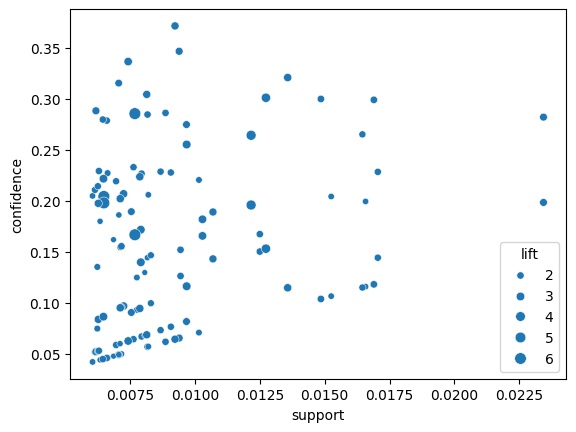

In [ ]:
# Generate scatterplot using support and confidence and lift as the size.
sns.scatterplot(x = "support", y = "confidence",
                size = "lift", data = rules)
plt.show()

After exploring the scatterplot one can go back and try different thresholds in the apriori algorithm and association rules.

## Parallel Coordinates Plot:

The parallel coordinates plot will allow us to visualize whether a rule exists between an antecedent and consequent.

A type of directed network diagram. This plot shows connections between two items that are related and indicates the direction of the relationship.

#### A parallel coordinates plot is useful when:

If we don't need information about intensity, only want information about whether a rule exists, and want a diagram with minimal visual clutter, it makes sense to use a parallel coordinates plot, rather than a heatmap.

Alternatively, if we want information about individual rules, aren't interested in the metric thresholds that are used to identify the rules, and only want to examine the rules themselves, we'll want to use a parallel coordinates plot, rather than a scatterplot.

The first step before we can plot the parallel coordinates diagram is to get the coordinated between the antecedent item and consequent one.

In [ ]:
# We Define the function to convert rules to coordinates
def rules_to_coordinates(rules):
    # Convert rules to coordinates
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index

    # Define coordinates and label
    coords = rules[['antecedent', 'consequent', 'rule']]
    return coords

Same as with the heatmap example, we need to filter out rules so that we don't have end up with huge amount that will make it difficult to understand the relationships between items.



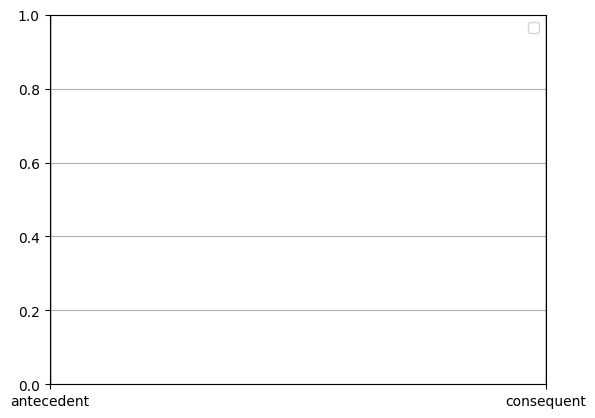

In [ ]:
# THIS WILL BE TOO MESSY WITH MANY PRODUCTS



# Import the parallel coordinates plot submodule
from pandas.plotting import parallel_coordinates

# Compute the frequent itemsets
frequent_itemsets = apriori(onehot, min_support = 0.03,
                        use_colnames = True, max_len = 2)

# Compute rules from the frequent itemsets with the zhangs' metric
rules = association_rules(frequent_itemsets, metric = 'zhangs_metric',
                          min_threshold = 0.06)

# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(rules)


# Generate parallel coordinates plot
parallel_coordinates(coords, 'rule', colormap='ocean')
plt.legend([])
plt.show()
